In [ ]:
#Hopfield Network

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import ttest_ind

# Load the log-normalized data
data_log_normalized = pd.read_csv('IDHWT_log_normalized.csv')

# Remove duplicate gene names
data_log_normalized = data_log_normalized.drop_duplicates(subset=['Gene'])

# Extract genes and expression data
genes = data_log_normalized['Gene'].values
expression_data = data_log_normalized.drop(columns=['Gene']).values

# Ensure the correct dimensions for expression data
num_genes, num_cells = expression_data.shape

# Create a Hopfield network
class HopfieldNetwork:
    def __init__(self, num_neurons):
        self.num_neurons = num_neurons
        self.weights = np.zeros((num_neurons, num_neurons))
    
    def train(self, patterns):
        for p in patterns:
            self.weights += np.outer(p, p)
        np.fill_diagonal(self.weights, 0)
    
    def energy(self, state):
        return -0.5 * state @ self.weights @ state.T
    
    def update(self, state):
        return np.sign(self.weights @ state)

# Normalize and binarize the expression data for Hopfield network training
expression_data_normalized = (expression_data - expression_data.mean(axis=0)) / expression_data.std(axis=0)
expression_data_binarized = np.where(expression_data_normalized > 0, 1, -1).T

# Train Hopfield network
hopfield_net = HopfieldNetwork(num_genes)
hopfield_net.train(expression_data_binarized)

# Generate random states and compute their energies
num_states = 1000
states = [np.random.choice([-1, 1], num_genes) for _ in range(num_states)]
energies = [hopfield_net.energy(state) for state in states]

# Save the energies along with the corresponding states
energy_states_df = pd.DataFrame(states, columns=genes)
energy_states_df['Energy'] = energies

# Determine the optimal number of clusters using the silhouette score
max_clusters = 10
silhouette_scores = []
for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(states)
    silhouette_avg = silhouette_score(states, cluster_labels)
    silhouette_scores.append((n_clusters, silhouette_avg))

# Find the optimal number of clusters
optimal_clusters = max(silhouette_scores, key=lambda x: x[1])[0]

# Perform K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters)
cluster_labels = kmeans.fit_predict(states)
energy_states_df['Cluster'] = cluster_labels

import matplotlib.pyplot as plt

# Ensure the correct conversion of index and energy values to numpy arrays for plotting
plt.figure(figsize=(10, 6))
for cluster in range(optimal_clusters):
    cluster_states = energy_states_df[energy_states_df['Cluster'] == cluster]
    plt.plot(cluster_states.index.to_numpy(), cluster_states['Energy'].to_numpy(), 'o', markersize=2, label=f'Cluster {cluster}')
plt.xlabel('State Index')
plt.ylabel('Energy')
plt.title('2D Energy Landscape of Hopfield Network by Clusters')
plt.legend()
plt.grid(True)
plt.savefig('2D_Energy_Landscape_Clusters.jpeg', format='jpeg')
plt.show()

In [8]:
# Identify DEGs for each K-means cluster
def find_deg(expression_data, cluster_labels, cluster_num):
    cluster_indices = np.where(cluster_labels == cluster_num)[0]
    other_indices = np.where(cluster_labels != cluster_num)[0]
    degs = []
    for gene_idx in range(num_genes):
        cluster_gene_expression = expression_data[gene_idx, cluster_indices]
        other_gene_expression = expression_data[gene_idx, other_indices]
        _, p_value = ttest_ind(cluster_gene_expression, other_gene_expression)
        if p_value < 0.05:  # Use a p-value threshold for significance
            mean_diff = np.mean(cluster_gene_expression) - np.mean(other_gene_expression)
            degs.append((genes[gene_idx], mean_diff, p_value))
    return degs

# Save DEGs for each K-means cluster
all_degs = {}
for cluster_num in range(optimal_clusters):
    degs = find_deg(expression_data, cluster_labels, cluster_num)
    degs_df = pd.DataFrame(degs, columns=['Gene', 'Mean_Difference', 'P_Value'])
    degs_df.to_csv(f'Cluster_{cluster_num}_DEGs.csv', index=False)
    all_degs[cluster_num] = degs_df

# Identify DEGs for each energy state range
def find_deg_energy_ranges(expression_data, energy_states_df, lower_bound, upper_bound):
    indices = energy_states_df[(energy_states_df['Energy'] >= lower_bound) & (energy_states_df['Energy'] < upper_bound)].index
    other_indices = energy_states_df[(energy_states_df['Energy'] < lower_bound) | (energy_states_df['Energy'] >= upper_bound)].index
    degs = []
    for gene_idx in range(num_genes):
        range_gene_expression = expression_data[gene_idx, indices]
        other_gene_expression = expression_data[gene_idx, other_indices]
        _, p_value = ttest_ind(range_gene_expression, other_gene_expression)
        if p_value < 0.05:  # Use a p-value threshold for significance
            mean_diff = np.mean(range_gene_expression) - np.mean(other_gene_expression)
            degs.append((genes[gene_idx], mean_diff, p_value))
    return degs

# Define energy state ranges
energy_ranges = [(-np.inf, -1), (-1, 0), (0, np.inf)]
range_labels = ['below_-1', 'between_-1_and_0', 'above_0']

# Save DEGs for each energy state range
for i, (lower, upper) in enumerate(energy_ranges):
    degs = find_deg_energy_ranges(expression_data, energy_states_df, lower, upper)
    degs_df = pd.DataFrame(degs, columns=['Gene', 'Mean_Difference', 'P_Value'])
    degs_df.to_csv(f'Energy_Range_{range_labels[i]}_DEGs.csv', index=False)

print("DEGs for K-means clusters and energy state ranges saved.")


DEGs for K-means clusters and energy state ranges saved.


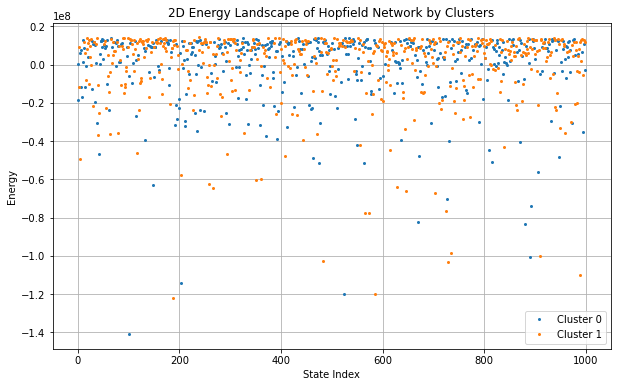

In [11]:
import matplotlib.pyplot as plt

# Ensure the correct conversion of index and energy values to numpy arrays for plotting
plt.figure(figsize=(10, 6))
for cluster in range(optimal_clusters):
    cluster_states = energy_states_df[energy_states_df['Cluster'] == cluster]
    plt.plot(cluster_states.index.to_numpy(), cluster_states['Energy'].to_numpy(), 'o', markersize=2, label=f'Cluster {cluster}')
plt.xlabel('State Index')
plt.ylabel('Energy')
plt.title('2D Energy Landscape of Hopfield Network by Clusters')
plt.legend()
plt.grid(True)
plt.savefig('2D_Energy_Landscape_Clusters.jpeg', format='jpeg')
plt.show()

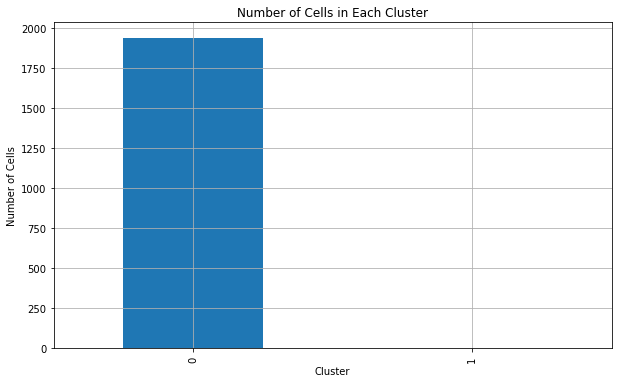

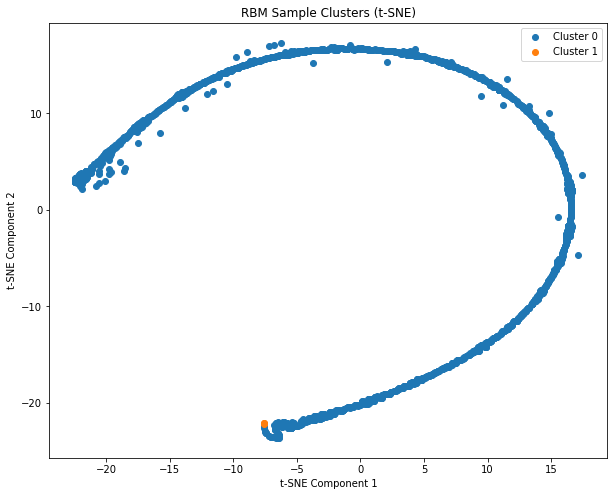

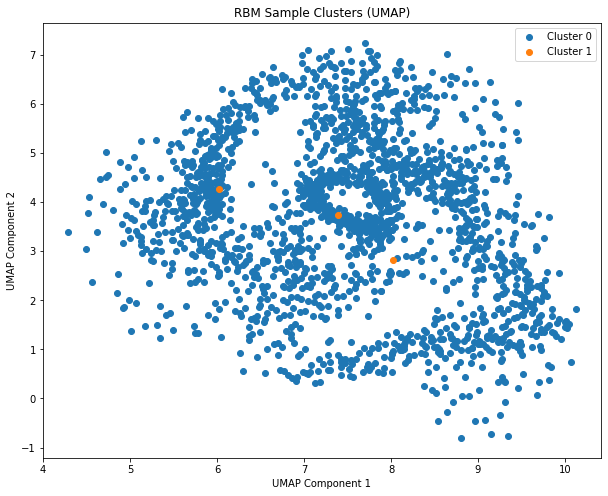

RBM attractors, DEGs, cluster counts, and plots saved.


In [12]:
#RBM Boltzmann Machine

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import BernoulliRBM
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from scipy.stats import ttest_ind

# Load the log-normalized data
data_log_normalized = pd.read_csv('IDHWT_log_normalized.csv')

# Remove duplicate gene names
data_log_normalized = data_log_normalized.drop_duplicates(subset=['Gene'])

# Extract genes and expression data
genes = data_log_normalized['Gene'].values
expression_data = data_log_normalized.drop(columns=['Gene']).values

# Ensure the correct dimensions for expression data
num_genes, num_cells = expression_data.shape

# Normalize data for RBM
scaler = MinMaxScaler()
expression_data_scaled = scaler.fit_transform(expression_data)

# Define the RBM model
rbm = BernoulliRBM(n_components=100, learning_rate=0.01, batch_size=10, n_iter=25, random_state=42)
rbm.fit(expression_data_scaled.T)  # Transpose to fit the RBM correctly

# Generate samples using MCMC
num_samples = num_cells
initial_state = np.random.rand(num_cells, num_genes)
samples = rbm.transform(initial_state)

# Perform PCA for visualization purposes
pca = PCA(n_components=2)
pca_samples = pca.fit_transform(samples)

# Perform K-means clustering to identify attractors
max_clusters = 10
silhouette_scores = []
for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_samples)
    silhouette_avg = silhouette_score(pca_samples, cluster_labels)
    silhouette_scores.append((n_clusters, silhouette_avg))

# Find the optimal number of clusters
optimal_clusters = max(silhouette_scores, key=lambda x: x[1])[0]
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(pca_samples)

# Add cluster labels to the samples
samples_df = pd.DataFrame(samples, columns=[f'Component_{i}' for i in range(samples.shape[1])])
samples_df['Cluster'] = cluster_labels

# Save the samples with cluster labels
samples_df.to_csv('RBM_Samples_Clusters.csv', index=False)

# Identify differentially expressed genes (DEGs) in each cluster
def find_deg(expression_data, cluster_labels, cluster_num):
    cluster_indices = np.where(cluster_labels == cluster_num)[0]
    other_indices = np.where(cluster_labels != cluster_num)[0]
    degs = []
    for gene_idx in range(num_genes):
        cluster_gene_expression = expression_data[gene_idx, cluster_indices]
        other_gene_expression = expression_data[gene_idx, other_indices]
        _, p_value = ttest_ind(cluster_gene_expression, other_gene_expression)
        if p_value < 0.05:  # Use a p-value threshold for significance
            mean_diff = np.mean(cluster_gene_expression) - np.mean(other_gene_expression)
            degs.append((genes[gene_idx], mean_diff, p_value))
    return degs

# Find DEGs for each cluster
all_degs = {}
for cluster_num in range(optimal_clusters):
    degs = find_deg(expression_data, cluster_labels, cluster_num)
    degs_df = pd.DataFrame(degs, columns=['Gene', 'Mean_Difference', 'P_Value'])
    degs_df.to_csv(f'Cluster_{cluster_num}_DEGs.csv', index=False)
    all_degs[cluster_num] = degs_df

# Count the number of cells in each cluster
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()

# Plot the number of cells in each cluster
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Cells')
plt.title('Number of Cells in Each Cluster')
plt.grid(True)
plt.savefig('Cluster_Cell_Counts.png')
plt.show()

# Visualize clusters with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_samples = tsne.fit_transform(samples)

plt.figure(figsize=(10, 8))
for cluster_num in range(optimal_clusters):
    cluster_samples = tsne_samples[cluster_labels == cluster_num]
    plt.scatter(cluster_samples[:, 0], cluster_samples[:, 1], label=f'Cluster {cluster_num}')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('RBM Sample Clusters (t-SNE)')
plt.legend()
plt.savefig('RBM_Sample_Clusters_tSNE.png')
plt.show()

# Visualize clusters with UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_samples = umap_model.fit_transform(samples)

plt.figure(figsize=(10, 8))
for cluster_num in range(optimal_clusters):
    cluster_samples = umap_samples[cluster_labels == cluster_num]
    plt.scatter(cluster_samples[:, 0], cluster_samples[:, 1], label=f'Cluster {cluster_num}')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('RBM Sample Clusters (UMAP)')
plt.legend()
plt.savefig('RBM_Sample_Clusters_UMAP.png')
plt.show()

print("RBM attractors, DEGs, cluster counts, and plots saved.")



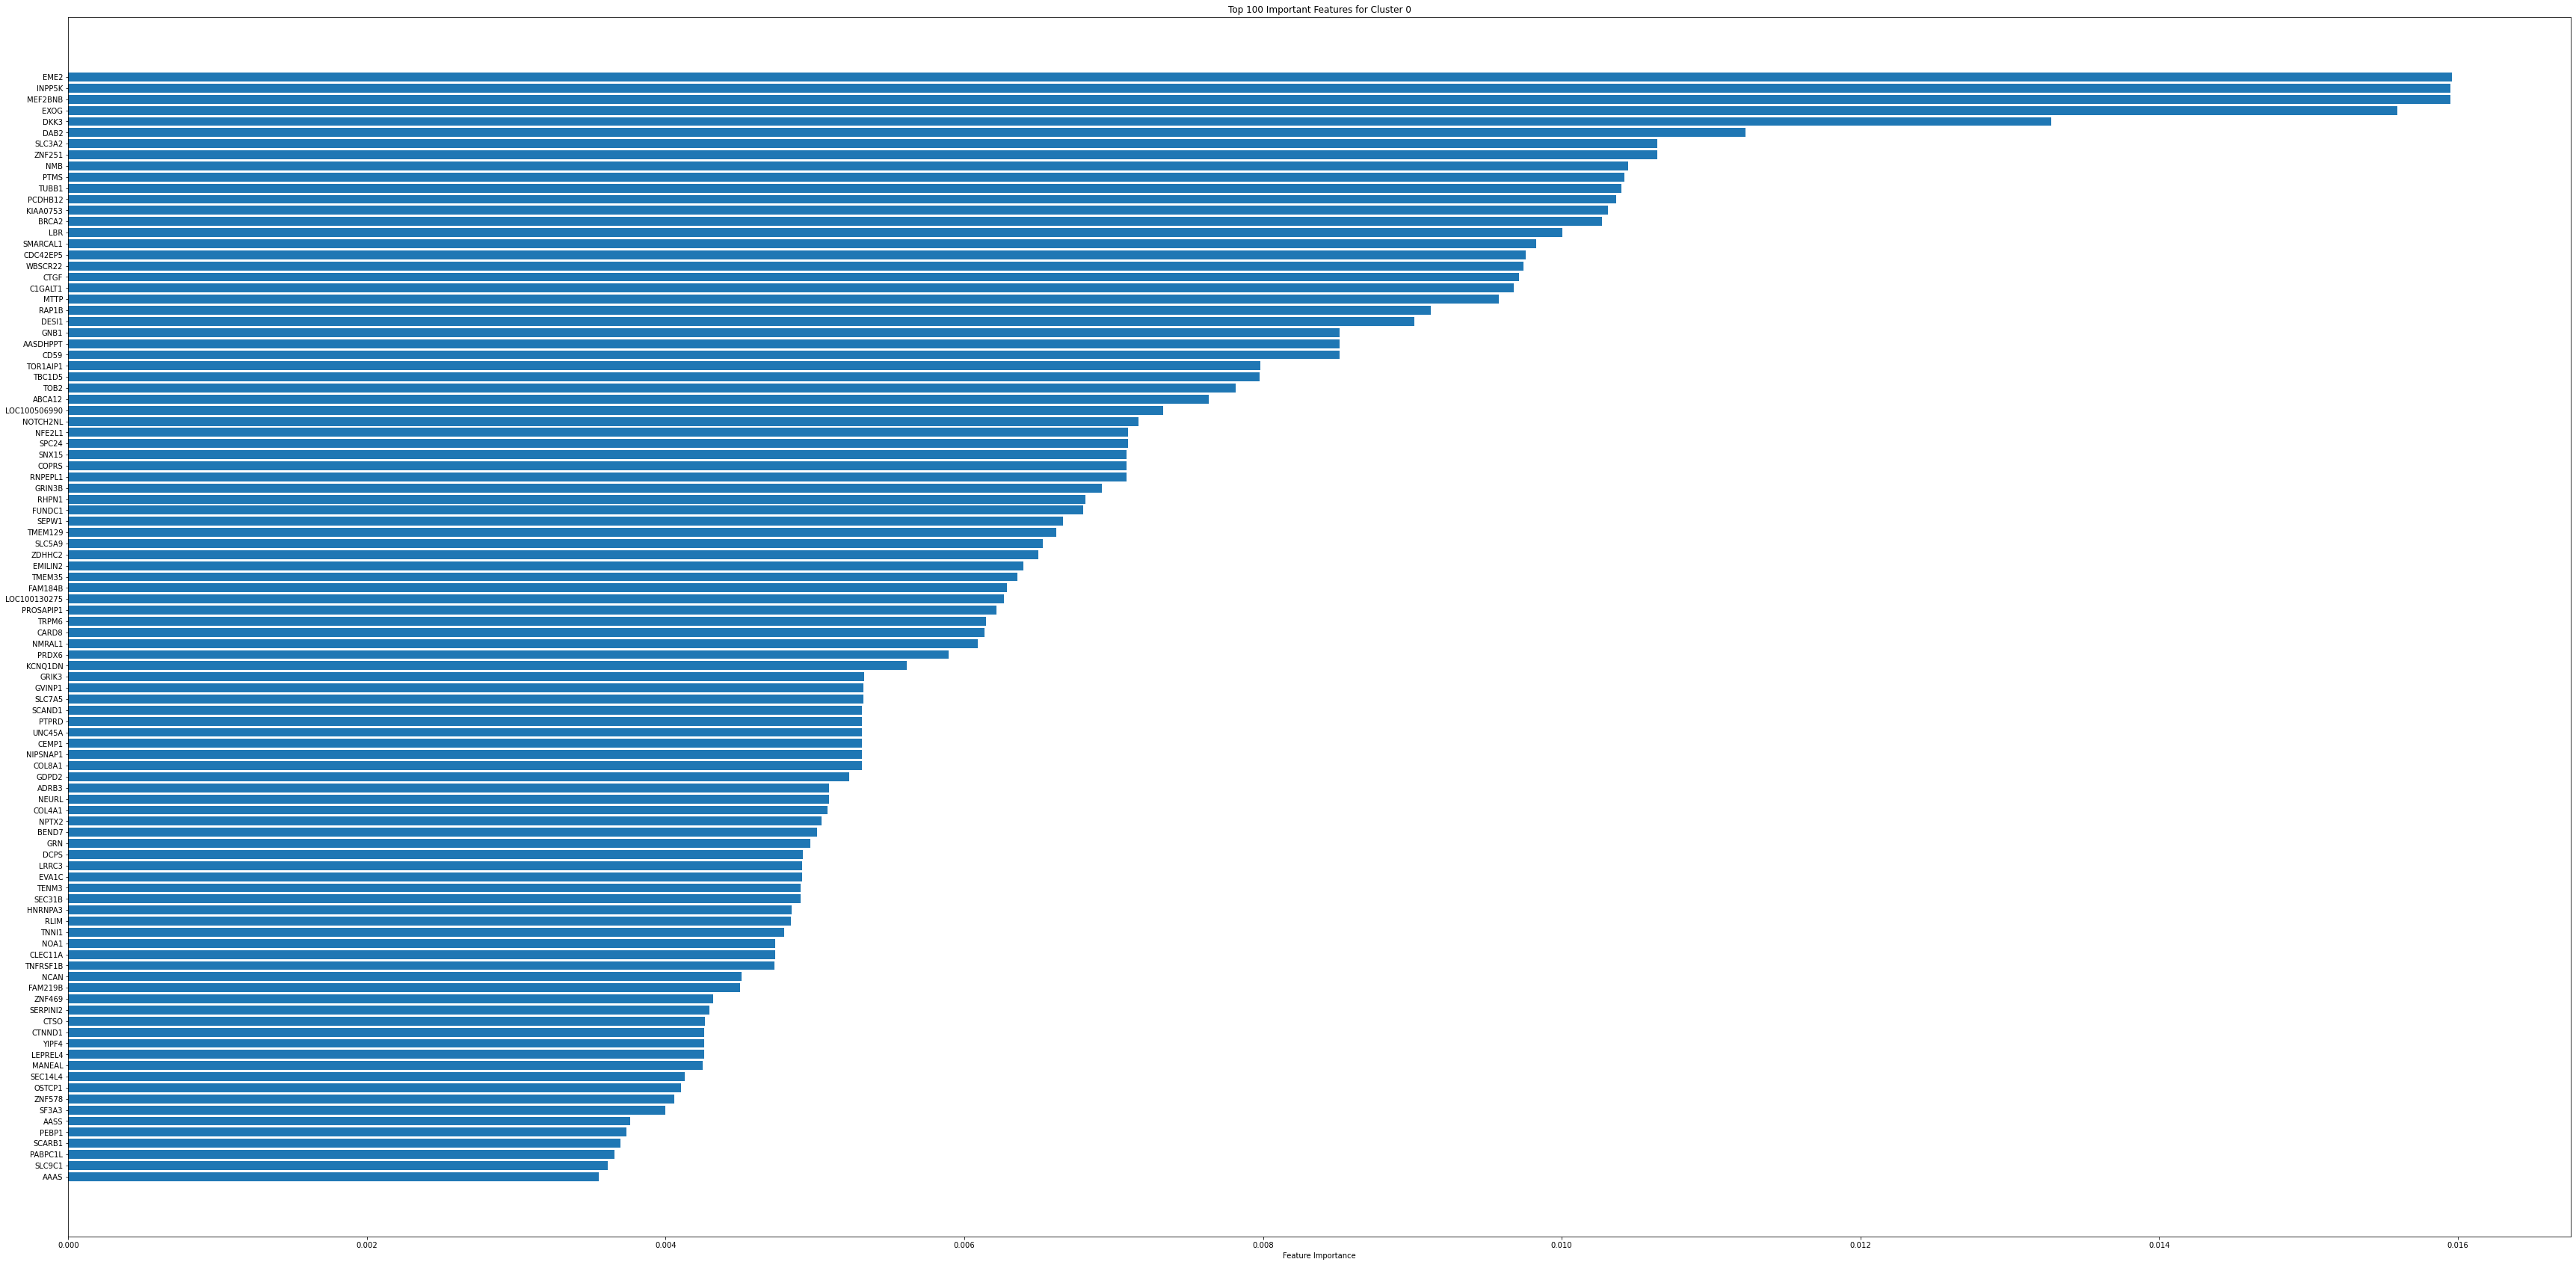

RBM attractors, DEGs, cluster counts, plots, and feature importances saved.


In [14]:
from sklearn.ensemble import RandomForestClassifier

# Perform Random Forest to extract feature importance for cluster 0
# Prepare the data
X = expression_data.T  # Transpose to get cells as rows and genes as columns
y = (cluster_labels == 0).astype(int)  # Binary classification: 1 for cluster 0, 0 for others

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Extract feature importance
feature_importance = rf.feature_importances_

# Get the top 100 features
top_features_idx = np.argsort(feature_importance)[-100:][::-1]
top_features = genes[top_features_idx]
top_importances = feature_importance[top_features_idx]

# Save the top features to a CSV file
top_features_df = pd.DataFrame({'Gene': top_features, 'Importance': top_importances})
top_features_df.to_csv('Top_Features_Cluster_0.csv', index=False)

# Plot the top features
plt.figure(figsize=(60, 30))
plt.barh(top_features, top_importances)
plt.xlabel('Feature Importance')
plt.title('Top 100 Important Features for Cluster 0')
plt.gca().invert_yaxis()
plt.savefig('Top_Features_Cluster_0.jpeg')
plt.show()

print("RBM attractors, DEGs, cluster counts, plots, and feature importances saved.")

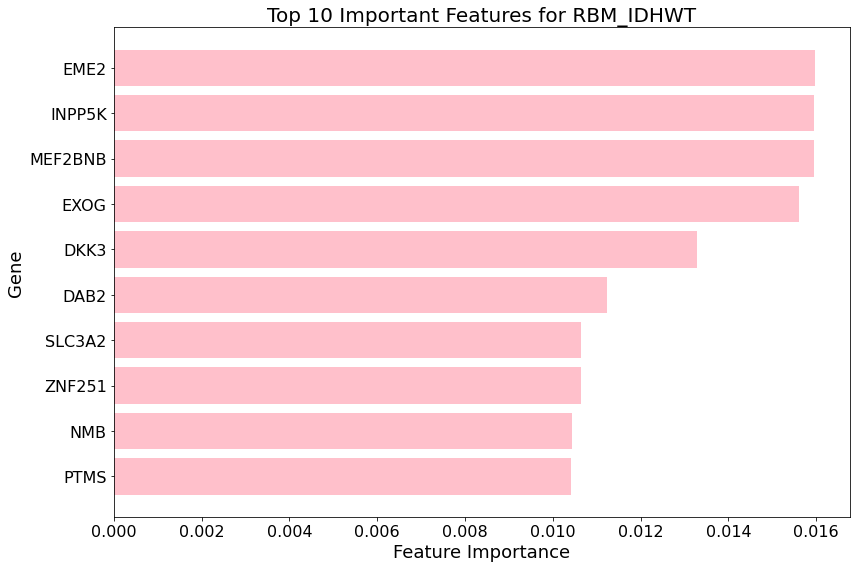

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Set the working directory (if needed)
os.chdir(r'C:\Users\uabic\Desktop')

# Load the top features CSV
top_features_df = pd.read_csv('Top_FeaturesIDHWT.csv')

# Extract the top 10 features
top_10_features = top_features_df.nlargest(10, 'Importance')

# Plot the top 10 features
plt.figure(figsize=(12, 8))
plt.barh(top_10_features['Gene'], top_10_features['Importance'], color='pink')
plt.xlabel('Feature Importance', fontsize=18)
plt.ylabel('Gene', fontsize=18)
plt.title('Top 10 Important Features for RBM_IDHWT', fontsize=20)
plt.gca().invert_yaxis()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('Top_10_Features_Cluster_IDHWT.jpeg', format='jpeg', pil_kwargs={'quality': 95})
plt.show()
